# Notebook that demonstrates the use of GMF models

In [1]:
from gammaALPs.bfields import gmf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Build coordinate arrays

First we build 3D coordinate arrays in galactocentric coordinates $(\rho, \phi, z)$, where $\rho$ and $z$ are in units of kpc. 

In [3]:
x = np.arange(-20.,20.1,0.1)
y = np.arange(-20.,20.1,0.1)
z = np.arange(-5.,5.01,0.01)
xx,yy,zz = np.meshgrid(x, y, z, indexing='ij')

In [4]:
rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

In [5]:
print (rr.shape)

(401, 401, 1001)


### Now initialize the GMF model. Models that are included are the Jansson & Farrar and the Pshirkov model.

### The Pshirkov model

For the Pshirkov model, both the bisymmetric (BSS) and the axisymmetric (ASS) versions are available.

In [6]:
pshirkov = gmf.GMFPshirkov(model='ASS')

Get the disk component for the plane where $z = 0$

In [7]:
idz = np.argmin(np.abs(z))
print (idz)

500


In [8]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = pshirkov.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

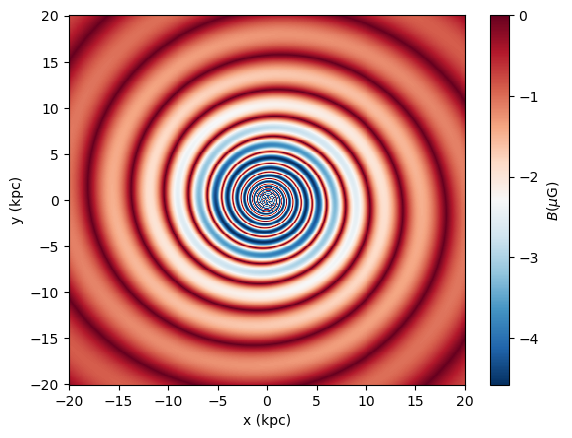

In [9]:
p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap = plt.cm.RdBu_r)
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

Get the halo component where $y = 0$

In [10]:
idy = np.argmin(np.abs(y))
print (idy)

200


In [11]:
Bhalo = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = pshirkov.Bhalo(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    Bhalo[i,:] = b[1]

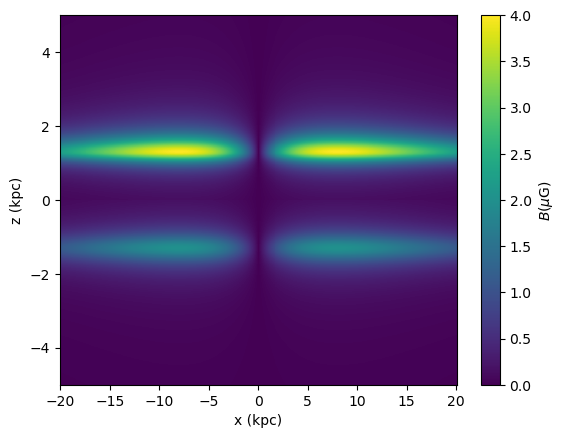

In [12]:
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

The total model at some for $y = 0$:

### The Jansson & Farrar model

In [13]:
jansson = gmf.GMF()

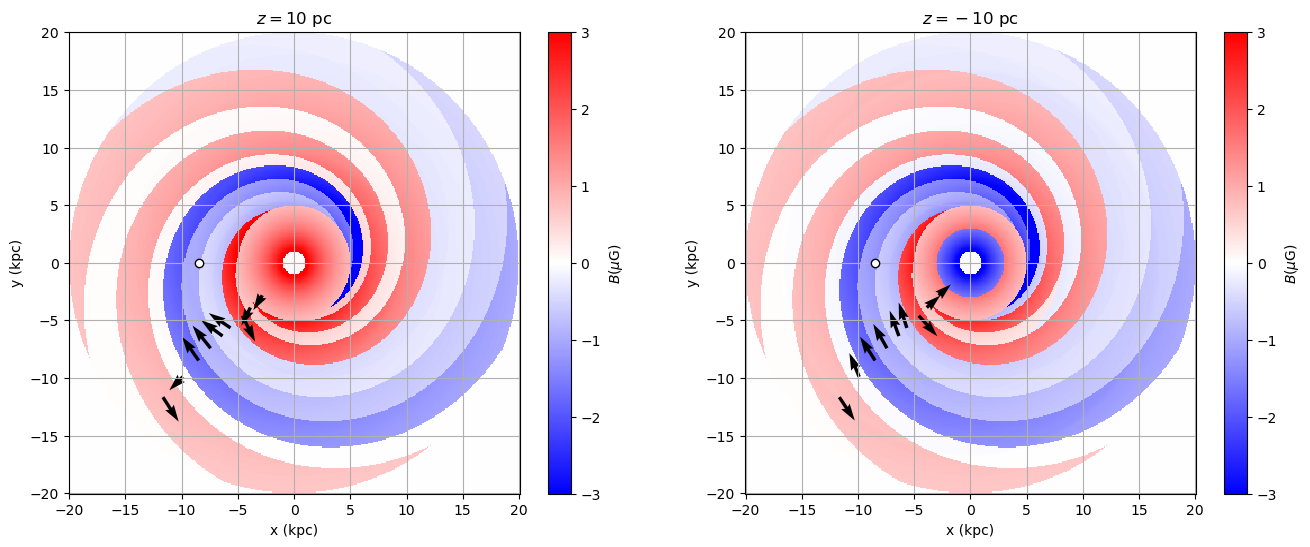

In [14]:
# position of arrows in plot
rho0 = np.array([4., 5.5, 6.5, 8., 9., 10.5, 12, 14., 16.5])
phi0 = np.array([5. * np.pi / 4.])

# plot B field at -10 and 10 pc
idzz = [np.argmin(np.abs(z - .01)), np.argmin(np.abs(z + .01))]

plt.figure(figsize=(8 * 2, 6))

for j, idz in enumerate(idzz):
    ax = plt.subplot(1,2,j+1)
    
    Bdisk_abs = np.zeros_like(rr[...,idz])
    Bdisk_all =  np.zeros([3] + list(rr[...,idz].shape))
    
    # B field over entire x-y plane
    for i,r in enumerate(rr[...,idz]):
        b = jansson.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz])[0]
        b += jansson.BX(r, z=zz[:,i,idz])[0]
        b += jansson.Bhalo(r, z=zz[:,i,idz])[0]
    
        sign = gmf.signum(b[1,:])
        Bdisk_all[:,i,...] = b
        Bdisk_abs[:,i] = np.sqrt(np.sum(Bdisk_all[:,i,...]**2., axis=0)) * sign
     
    # B field for arrow positions
    Bdisk = np.zeros([3, rho0.size])
    for i, r in enumerate(rho0):
        b = jansson.Bdisk(np.array([r]), phi0, z=z[idz])[0]
        b += jansson.BX(np.array([r]), z=np.array([z[idz]]))[0]
        b += jansson.Bhalo(np.array([r]), z=np.array([z[idz]]))[0]
        Bdisk[:,i] = b[:,0]
        
    # transform to cartesian coordinates
    Bdisk_x = np.zeros_like(Bdisk)  # disk component in cartesian coordinates
    Bdisk_x[0] = np.cos(phi0) * Bdisk[0] - np.sin(phi0) * Bdisk[1]
    Bdisk_x[1] = np.sin(phi0) * Bdisk[0] + np.cos(phi0) * Bdisk[1]
    Bdisk_x[2] = Bdisk[2]
    
    # plot
    p = ax.pcolormesh(xx[...,idz], yy[...,idz], Bdisk_abs, cmap=plt.cm.bwr, vmin=-3, vmax=3)
    plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

    ax.quiver(rho0 * np.cos(phi0), rho0 * np.sin(phi0),
           Bdisk_x[0] / np.sqrt(np.sum(Bdisk_x**2., axis = 0)),
           Bdisk_x[1] / np.sqrt(np.sum(Bdisk_x**2., axis = 0)),
          )


    ax.set_xlabel('x (kpc)')
    ax.set_ylabel('y (kpc)')
    ax.plot(-8.5, 0., marker='o', mec='k', mfc='w')
    ax.set_title("$z = {0:.0f}$ pc".format(z[idz] * 1000))
    ax.grid()

In [15]:
Bhalo = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = jansson.Bhalo(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    Bhalo[i,:] = b[1]

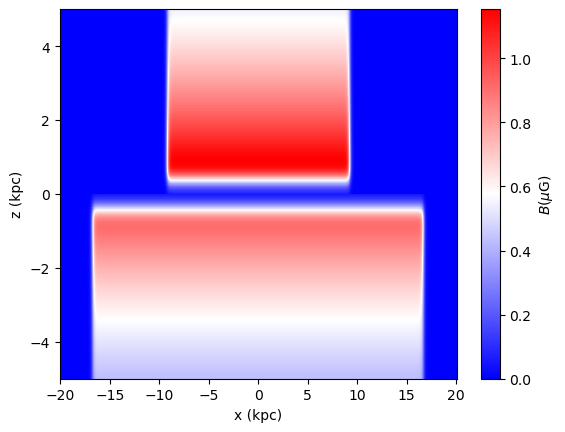

In [16]:
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo, cmap=plt.cm.bwr)
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label='$B (\mu\mathrm{G})$')

# X component at $y=0$

In [17]:
idy = np.argmin(np.abs(y))
print (idy)

200


In [18]:
BX = np.zeros([3] + list(xx[:,idy,:].shape))
BX_abs = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = jansson.BX(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    BX_abs[i,:] = b[1]
    BX[:, i, :] = b[0]

In [19]:
# convert to cartesian coordinates, phi component is zero
BX_x = BX[0] * np.cos(pp[:,idy,...])
BX_y = BX[0] * np.sin(pp[:,idy,...])

BX_z = BX[2]

-0.7000000000000917
2.8421709430404007e-13


/var/folders/v0/jcdj_5q15lq7qlkkb_7gphbw0000gq/T/ipykernel_98305/4145085691.py:9: RuntimeWarning: invalid value encountered in divide
  BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
/var/folders/v0/jcdj_5q15lq7qlkkb_7gphbw0000gq/T/ipykernel_98305/4145085691.py:17: RuntimeWarning: invalid value encountered in divide
  BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],


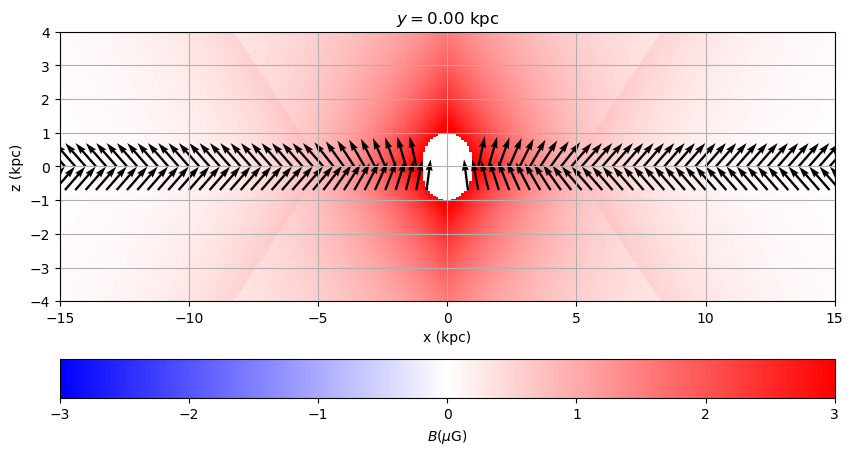

In [20]:
plt.figure(figsize=(10,5))
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], BX_abs, cmap=plt.cm.bwr, vmin=-3, vmax=3)
plt.colorbar(p, label = '$B (\mu\mathrm{G})$', orientation='horizontal')

# z = 0
idz = int(len(z) / 2)
step = 4
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
           width=3e-3, scale=25
          )

# z = -1pc
idz = int(len(z) / 2) - 70
print(z[idz])
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
           width=3e-3, scale=25
          )

plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-15, 15)
plt.ylim(-4,4)
plt.title(f"$y = {y[idy]:.2f}$ kpc")
plt.grid()
print(y[idy])

# X component at $x=0$

In [21]:
idx = np.argmin(np.abs(x))
print (idx)

200


In [22]:
BX = np.zeros([3] + list(yy[idx,:,:].shape))
print(BX.shape)
BX_abs = np.zeros_like(yy[idx,:,:])
for i,yi in enumerate(yy[idx,:,:]):
    b = jansson.BX(rho=np.sqrt(x[idx]**2. + yi**2.),
                       z=zz[idx,i,:]) 
    BX_abs[i,:] = b[1]
    BX[:, i, :] = b[0]

(3, 401, 1001)


In [23]:
BX_x = BX[0] * np.cos(pp[idx,...])
BX_y = BX[0] * np.sin(pp[idx,...])

BX_z = BX[2]
BX_x.shape, BX_y.shape, BX_z.shape

((401, 1001), (401, 1001), (401, 1001))

-0.7000000000000917
2.8421709430404007e-13


/var/folders/v0/jcdj_5q15lq7qlkkb_7gphbw0000gq/T/ipykernel_98305/3960751360.py:9: RuntimeWarning: invalid value encountered in divide
  BX_y[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
/var/folders/v0/jcdj_5q15lq7qlkkb_7gphbw0000gq/T/ipykernel_98305/3960751360.py:17: RuntimeWarning: invalid value encountered in divide
  BX_y[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],


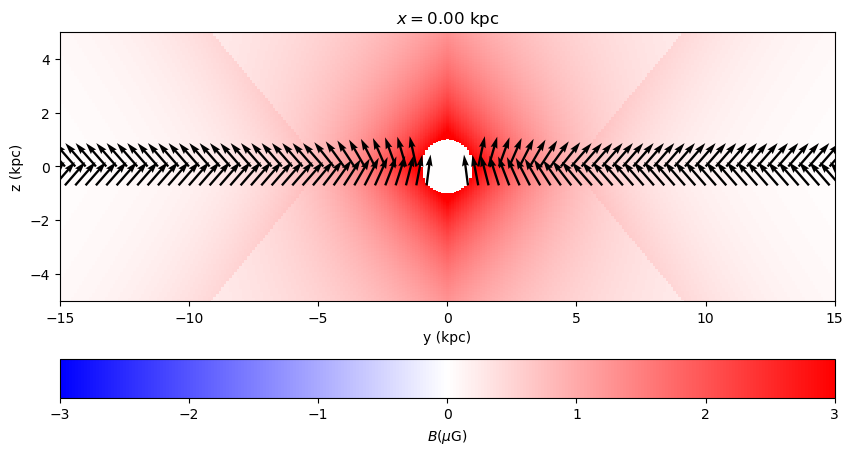

In [24]:
plt.figure(figsize=(10,5))
p = plt.pcolormesh(yy[idx,:,:], zz[idx,:,:], BX_abs, cmap=plt.cm.bwr, vmin=-3, vmax=3)
plt.colorbar(p, label = '$B (\mu\mathrm{G})$', orientation='horizontal')

# z = 0
idz = int(len(z) / 2)
step = 4
plt.quiver(yy[idx,:,idz][::step],  zz[idx,:,idz][::step],
           BX_y[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
           width=3e-3, scale=25
          )

# z = -1pc
idz = int(len(z) / 2) -70
print(z[idz])
plt.quiver(yy[idx,:,idz][::step],  zz[idx,:,idz][::step],
           BX_y[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
           width=3e-3, scale=25
          )

plt.xlabel('y (kpc)')
plt.ylabel('z (kpc)')
plt.xlim(-15, 15)
plt.ylim(-5,5)
plt.title(f"$x = {x[idx]:.2f}$ kpc")
print(y[idy])